In [1]:
import tensorflow as tf

import numpy as np
from PIL import Image
import pandas as pd
from keras.models import Model														  

import copy # for deep copies
import matplotlib.pyplot as plt
%matplotlib inline

print(np.__version__)
print(tf.__version__)

1.22.3
2.9.2


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
df = pd.read_csv('faceLandmarkTraining.csv') 

In [4]:
#print(df)
#print(df.iloc[2])

df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
# print("After .apply")
# df.head()

In [5]:
#reshaping the 1D arrays in the pandas dataframe to 2d numpy arrays

for i in range (0, df.shape[0]) :
    sample = df.iloc[i,30]
    
    reshaped = sample.reshape(96, 96)
    df.iat[i,30] = reshaped

print("2284th row: {}".format(df.iloc[2283,5]))
print("Row 2283 aka the 2284th row is the last row to contain most of the landmarks")
print("2285th row: {}".format(df.iloc[2284,5]))

#however there are other missing data values in the 1500- 1900 range so we gotta remove these ones

print("Original Shape {} ".format(df.shape))

df = df.dropna(axis=0, how="any", thresh=None, subset=None, inplace=False)
print("Dropped Shape {} ".format(df.shape))


2284th row: 36.0651428573
Row 2283 aka the 2284th row is the last row to contain most of the landmarks
2285th row: nan
Original Shape (7049, 31) 
Dropped Shape (2140, 31) 


 All Left Eye centers have had the pixels at their coordinates changed to white


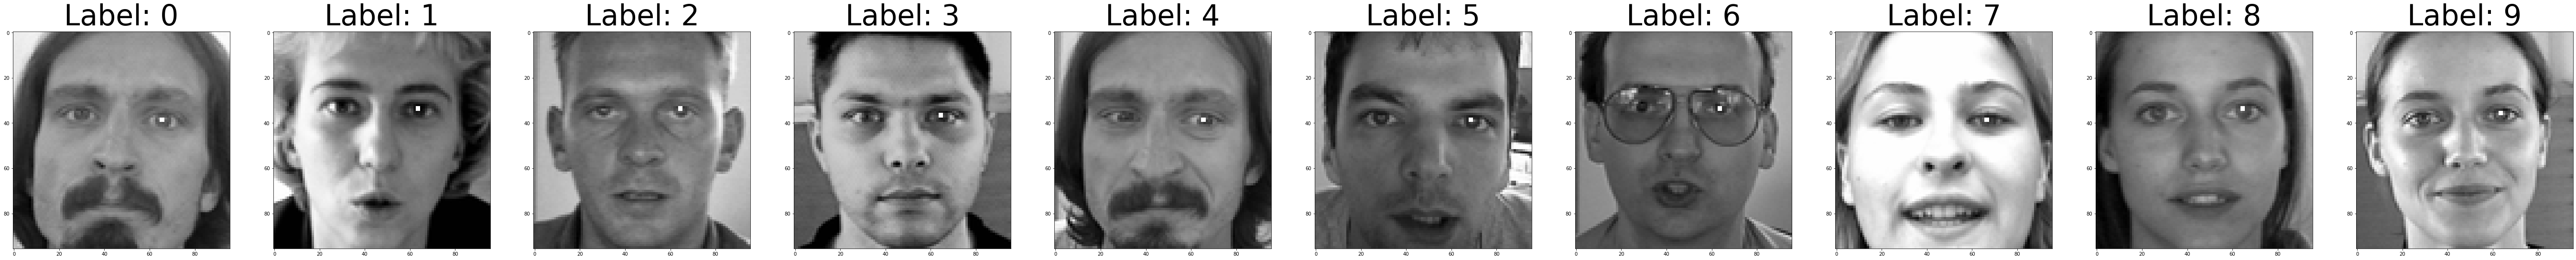

In [6]:
f, ax = plt.subplots(1, 10, figsize=(96,96))

for i in range (0, 10) :
    # print(df.iloc[i,30].shape)
    leftEyeX = df.iloc[i,0]
    leftEyeY = df.iloc[i,1]
    # tempArr = df.iat[i,30] # This is a shallow copy since when i changed tempArr it conversely changes the og dataframe
    tempArr = copy.deepcopy(df.iat[i,30])
    
    for j in range(-1,1):
        for k in range(-1,1):
            tempArr[(int)(leftEyeY+k),(int)(leftEyeX+j)] = 255
    # Numpy Arrays got their indexes backwards idfk
            
    # df.iat[i,30] = tempArr

    ax[i].imshow(tempArr, cmap='gray')
    ax[i].set_title( "Label: {}".format(i), fontsize=60)
print(" All Left Eye centers have had the pixels at their coordinates changed to white")


In [7]:
print(df.shape)
tempX = copy.deepcopy(df["Image"])
tempX = tempX / 255 # Normalized
tempY = copy.deepcopy(df.loc[: , "left_eye_center_x":"mouth_center_bottom_lip_y"])

trainPercentage = 0.9
numTrain = int(trainPercentage * df.shape[0])
xTrain = tempX[:numTrain][:]
yTrain = tempY[:numTrain][:] 
# slice indexing is not inclusive so should be fine
xTest = tempX[numTrain:][:]
yTest = tempY[numTrain:][:]

(2140, 31)


In [8]:

# Reshaping the dataframe so it is properly shaped

xTra = np.stack(xTrain.values)

xTra = xTra.reshape(xTra.shape[0],96, 96) # HARDCODED?
yTra = np.stack(yTrain.values)
yTra = yTra / 96


xTest = np.stack(xTest.values)

xTest = xTest.reshape(xTest.shape[0],96, 96) # HARDCODED?
yTest = np.stack(yTest.values)
yTest = yTest / 96 # normalized


print("xTra shape: {}".format(xTra.shape))
print("xTest shape: {}".format(xTest.shape))
print("yTra shape: {}".format(yTra.shape))
print("yTest shape: {}".format(yTest.shape))

    
def showImage(xDataset, yDataset, index): 
    img = xDataset[index]
    keypoints = yDataset[index][:]
    xKeypoints = keypoints[::2] * 96
    yKeypoints = keypoints[1::2] * 96
    plt.imshow(img, cmap='gray')
    plt.scatter(xKeypoints, yKeypoints, c = 'red')
    plt.show()

xTra shape: (1926, 96, 96)
xTest shape: (214, 96, 96)
yTra shape: (1926, 30)
yTest shape: (214, 30)


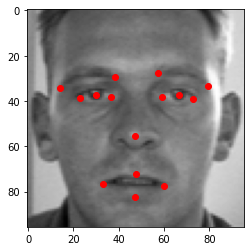

In [9]:
showImage(xTra, yTra, 480)

In [10]:
print(tf.keras.__version__)

from deeplabv3plusLambda import deeplabv3_plus
from dsntLambda import js_reg_loss

2.9.0


In [11]:
#tf.executing_eagerly()
# tf.compat.v1.disable_eager_execution()

# Huge Shoutout to user "off99555" for helping with dsnt implementation with keras model
# https://github.com/ashwhall/dsnt/blob/fab01af2792f98c00b2a0fa1e8acf314b0942185/dsnt.py

model = deeplabv3_plus(input_shape=(96,96,1),out_stride=16,num_classes=15) # wasnt sure if num_classes is number of landmarks or 
#model.summary()

input shape is the following: 96 96 1

output_shape: 6 

----------------
final shape of deeplab model (None, 86, 86, 15)
----------------


In [12]:
print(yTra[0][:2])
print(yTra.shape)

# 30
yTra = yTra.reshape(yTra.shape[0],15,2,order='C')
yTest = yTest.reshape(yTest.shape[0],15,2,order='C')

# Reshapes the landmarks from being organized as [ x1 ,y1 , x2 ,y2 .... x15,y 15] 
# to  [ x1, y1  ]
#     [ x2, y2  ]
#.    [ .....   ]
#.    [ x15, y15]

print(yTra[0][:2][:])
print(yTra.shape)

# def dsnt_loss(y_true, y_pred):
    
    # add regularization loss here later ig?
    
#     return loss
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# to Stop training if there is no improvements

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

#"huber_loss" loss was about like 45.something but with mean_square_error is like 2000

model.fit(xTra, yTra, batch_size=32, epochs=25, callbacks=[callback])

inputs = model.input   
outputs= model.get_layer('crop').output


[0.68784962 0.40627368]
(1926, 30)
[[0.68784962 0.40627368]
 [0.31486466 0.37939248]]
(1926, 15, 2)
Epoch 1/25
61/61 [==============================] - 47s 650ms/step - loss: 0.0182 - accuracy: 0.9498
Epoch 2/25
61/61 [==============================] - 39s 632ms/step - loss: 0.0146 - accuracy: 0.9748
Epoch 3/25
61/61 [==============================] - 39s 637ms/step - loss: 0.0144 - accuracy: 0.9753
Epoch 4/25
61/61 [==============================] - 39s 633ms/step - loss: 0.0143 - accuracy: 0.9773
Epoch 5/25
61/61 [==============================] - 40s 660ms/step - loss: 0.0142 - accuracy: 0.9783
Epoch 6/25
61/61 [==============================] - 39s 641ms/step - loss: 0.0142 - accuracy: 0.9793
Epoch 7/25
61/61 [==============================] - 39s 639ms/step - loss: 0.0141 - accuracy: 0.9811
Epoch 8/25
61/61 [==============================] - 38s 626ms/step - loss: 0.0141 - accuracy: 0.9808
Epoch 9/25
61/61 [==============================] - 39s 641ms/step - loss: 0.0141 - accuracy

In [13]:
# Evalution 
pureDLV3 = Model(inputs,outputs)

print(xTest[0][0][0])
print(yTest[0][0][0])
results = model.evaluate(xTest, yTest, batch_size=32)
print("test loss, test acc:", results)


0.023529411764705882
0.6975281201583333
7/7 [==============================] - 4s 282ms/step - loss: 0.0148 - accuracy: 0.9732
test loss, test acc: [0.0148019315674901, 0.9732087850570679]


7/7 [==============================] - 4s 293ms/step
[[0.69752812 0.4250522 ]]
(214, 15, 2)
[[0.60496724 0.44304612]]
size of heatmaps (214, 86, 86, 15)
(214, 86, 86, 15)
(214, 15, 86, 86)


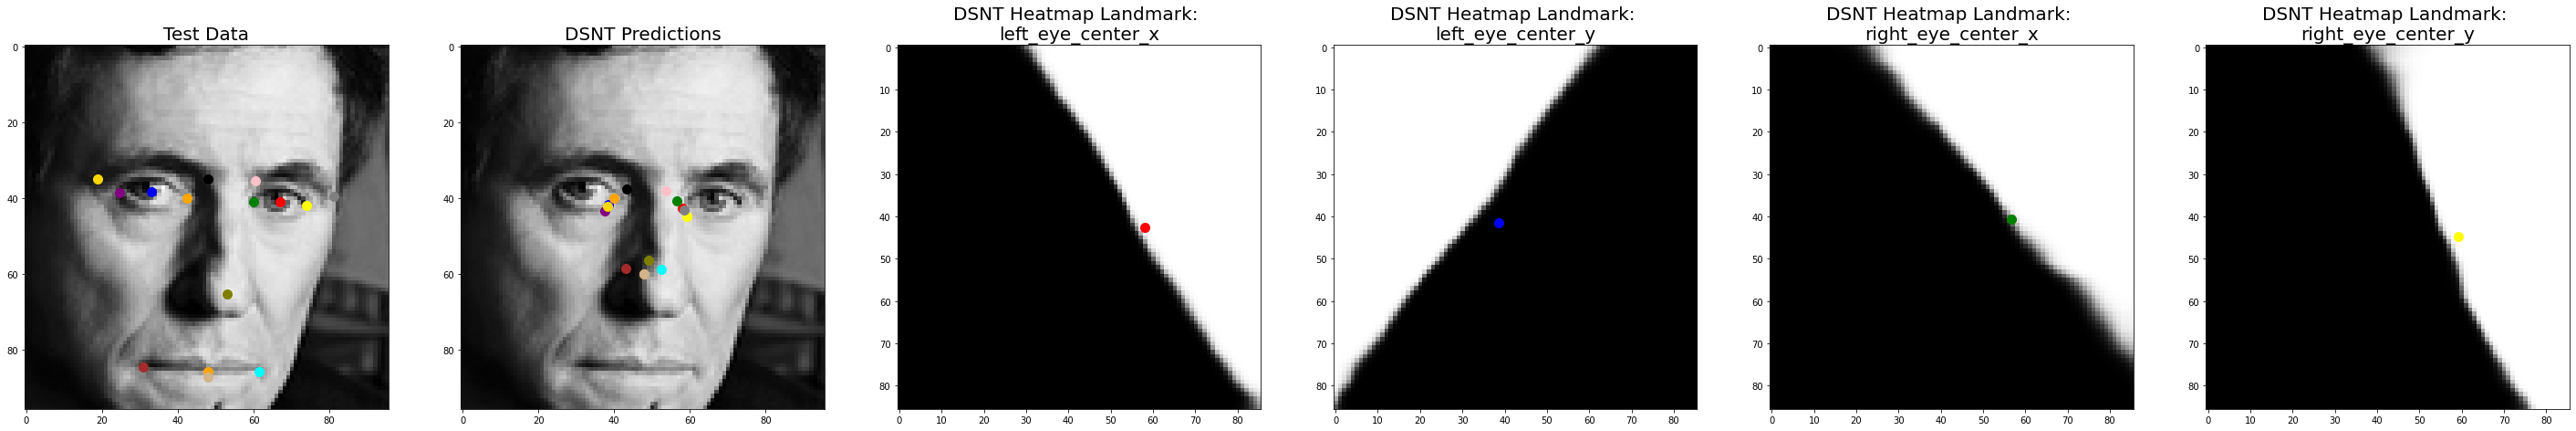

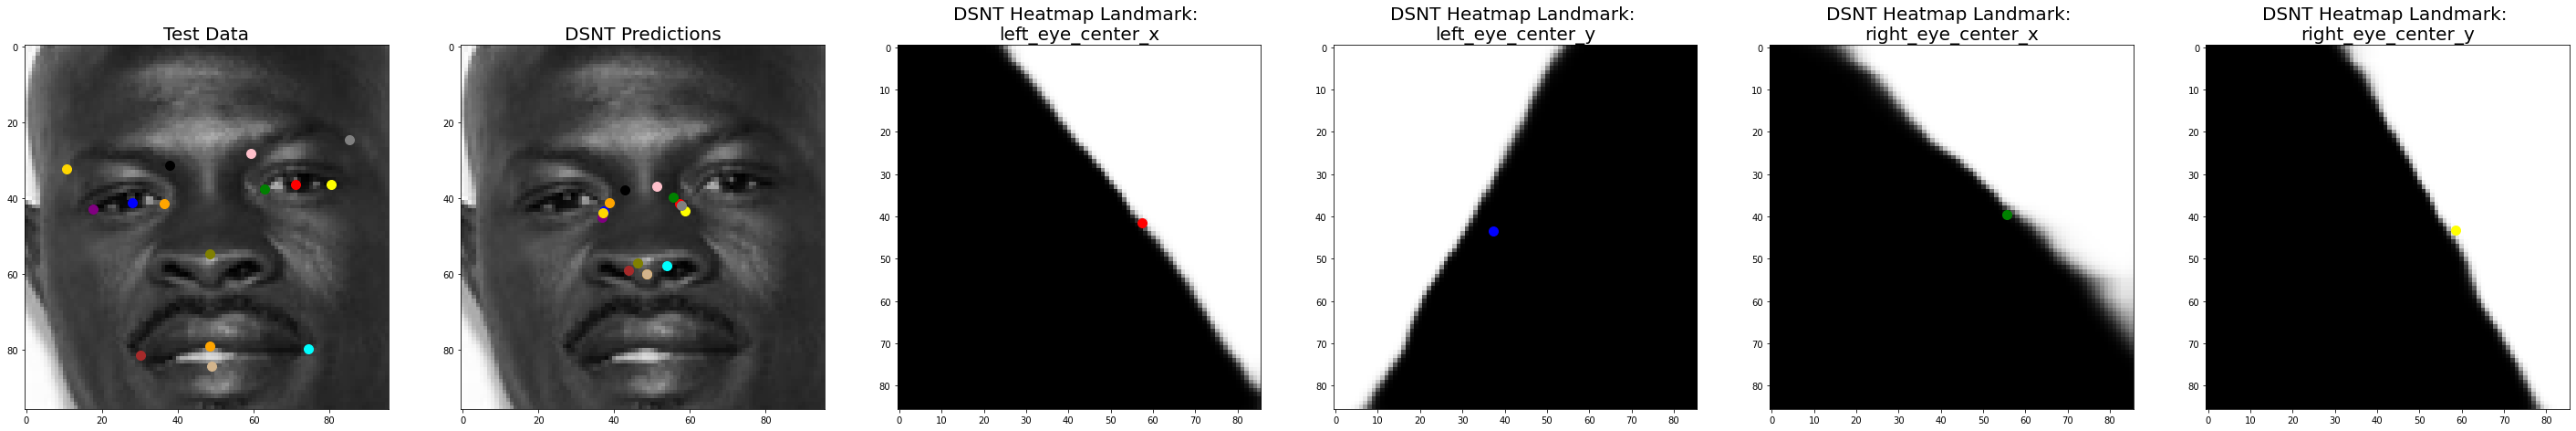

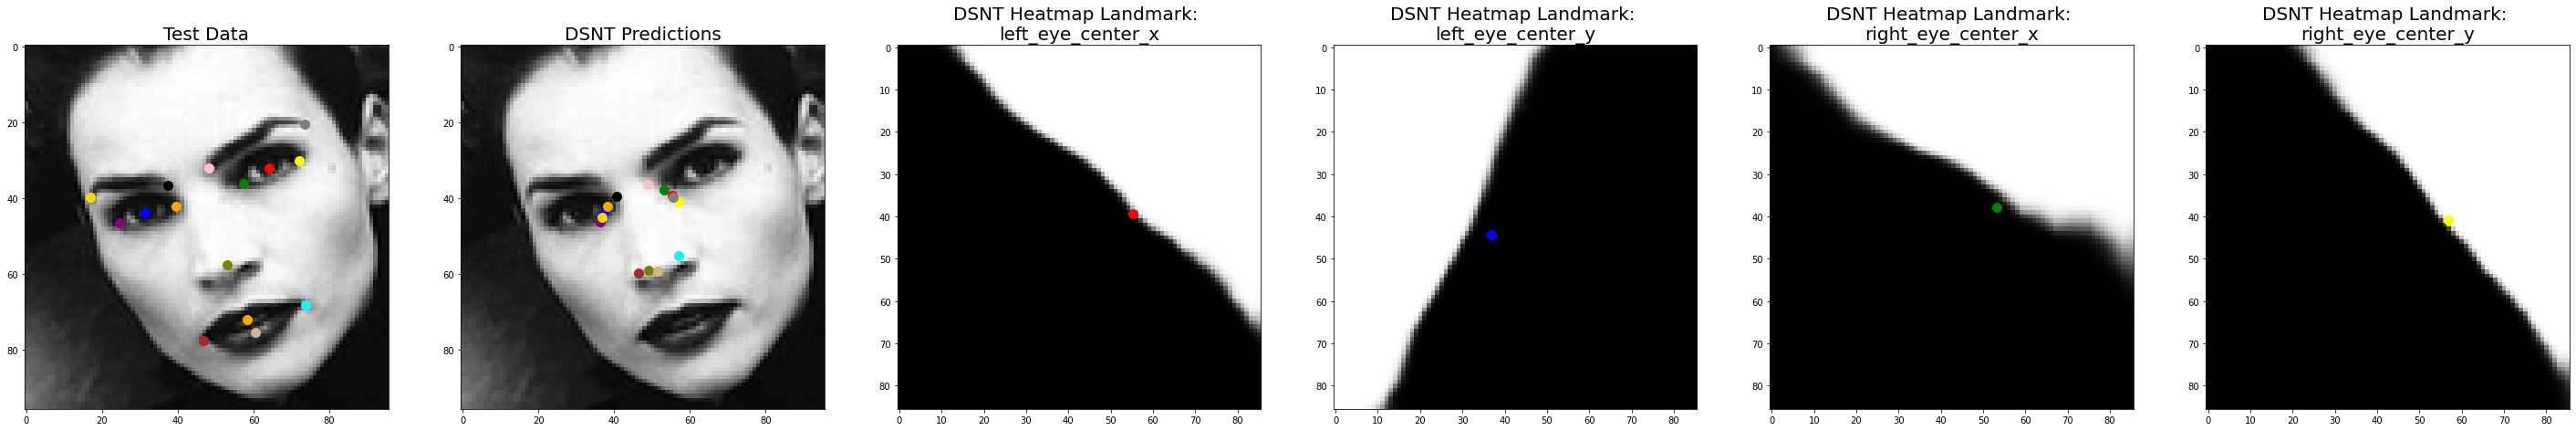

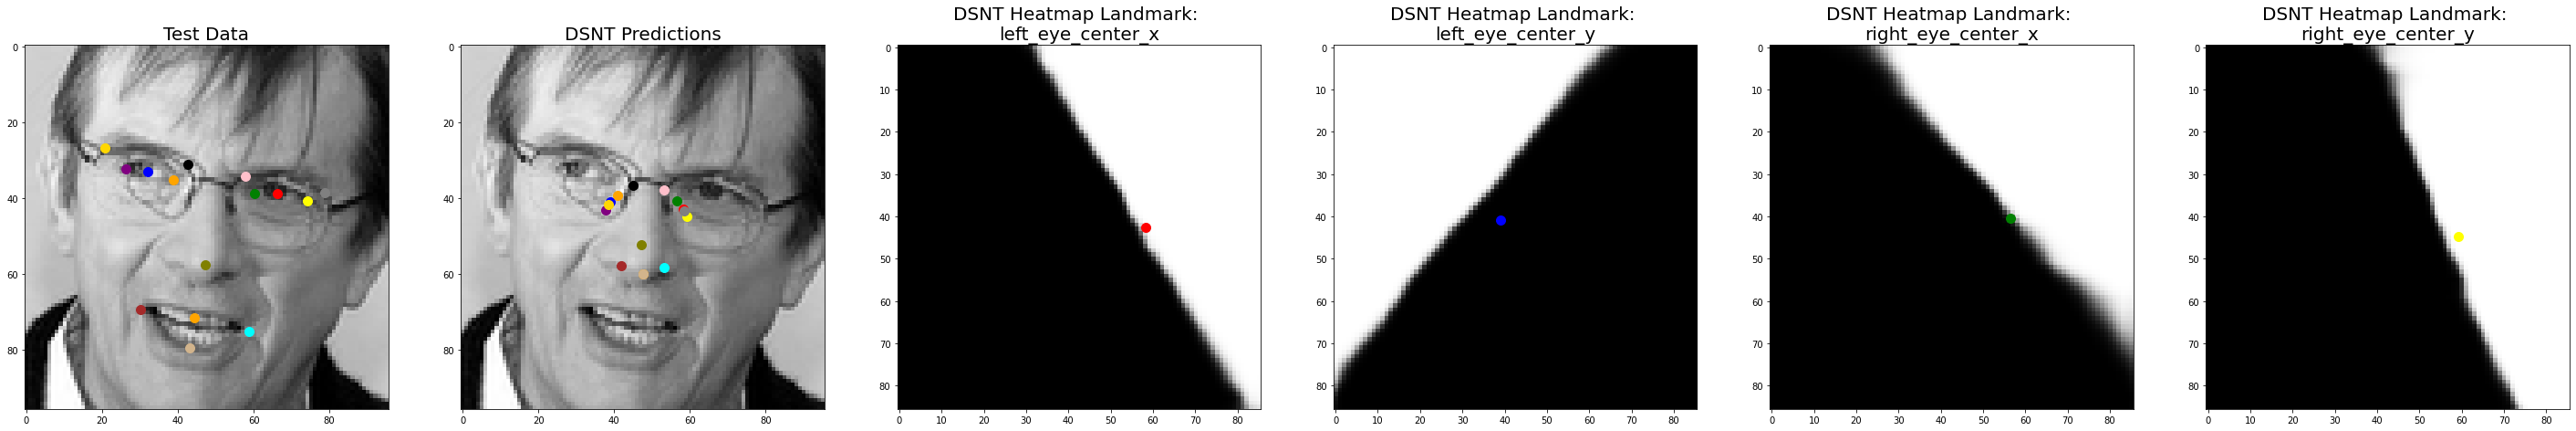

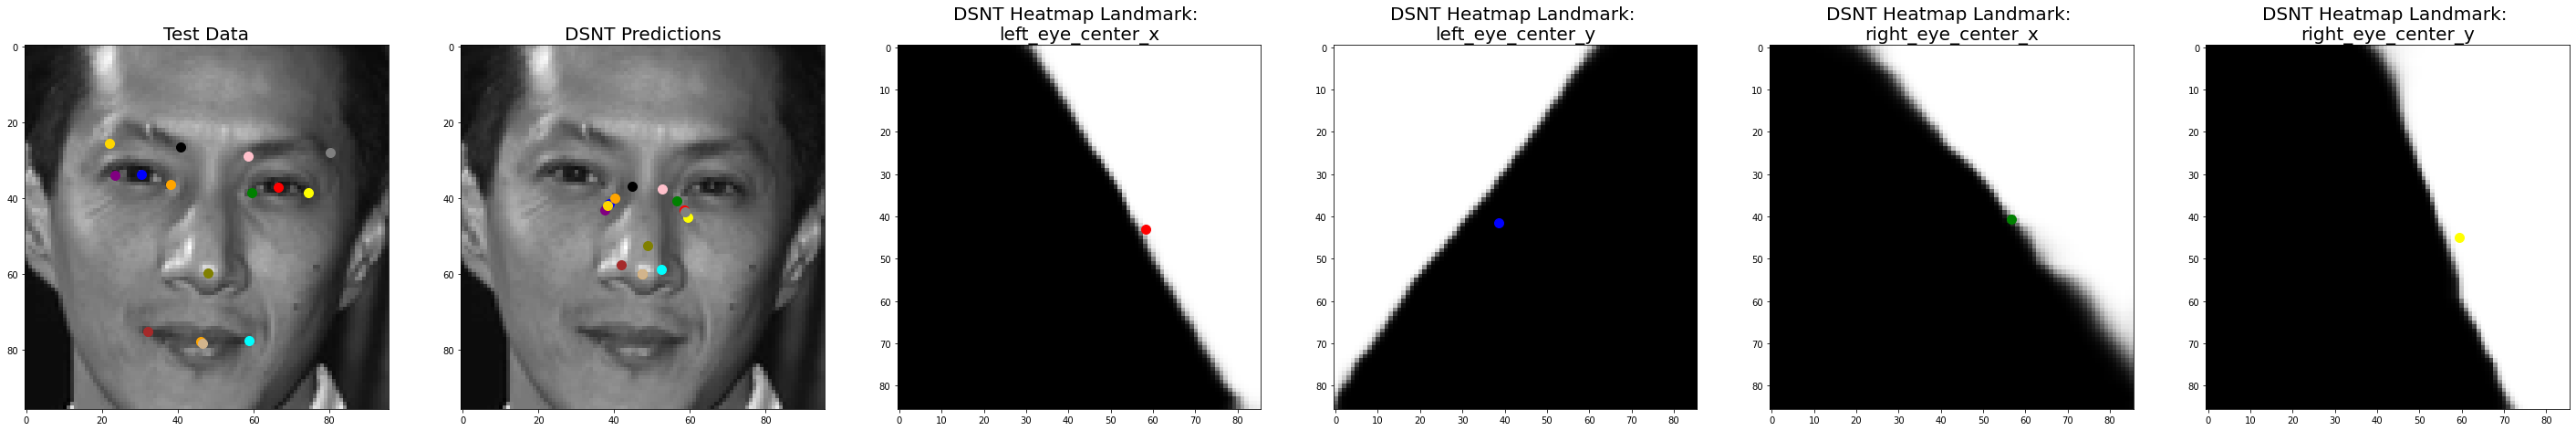

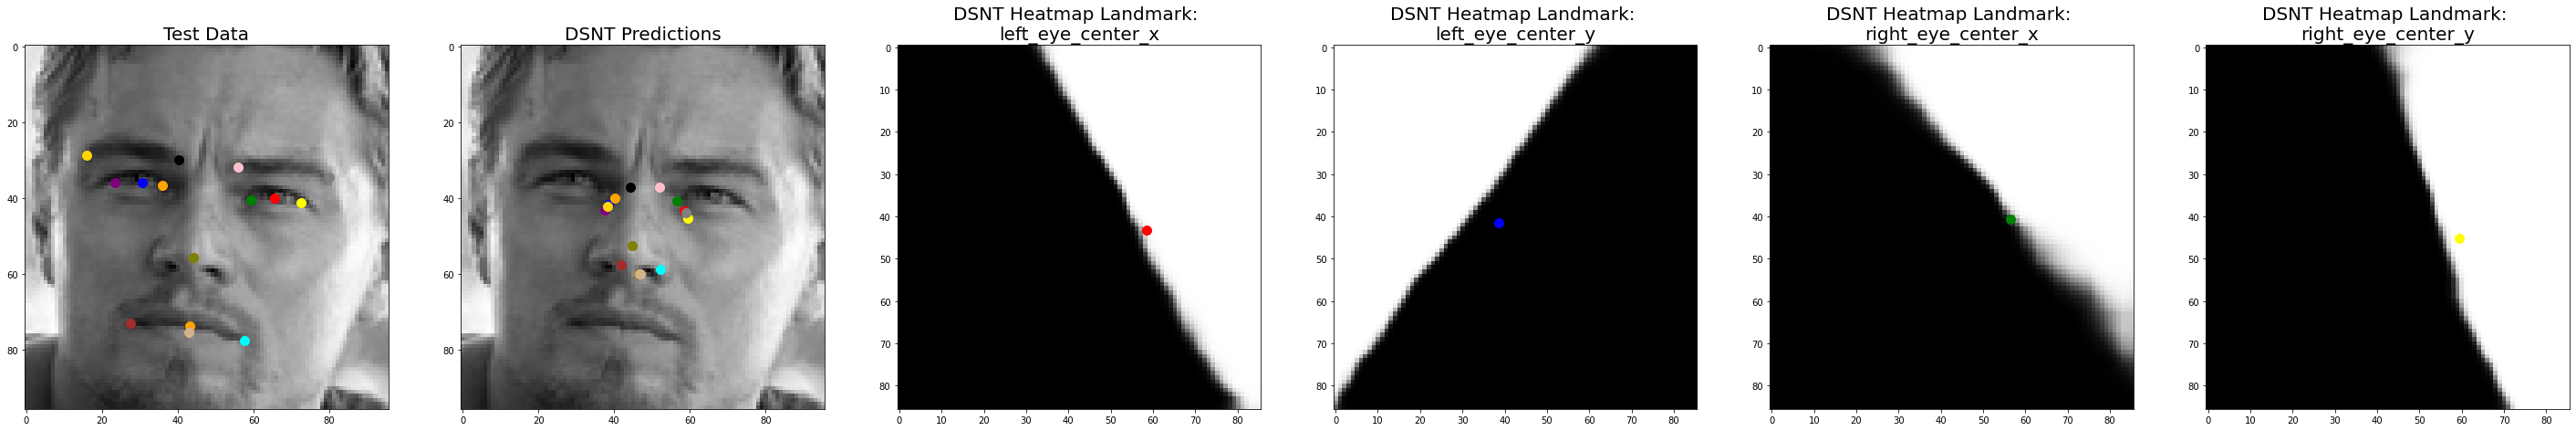

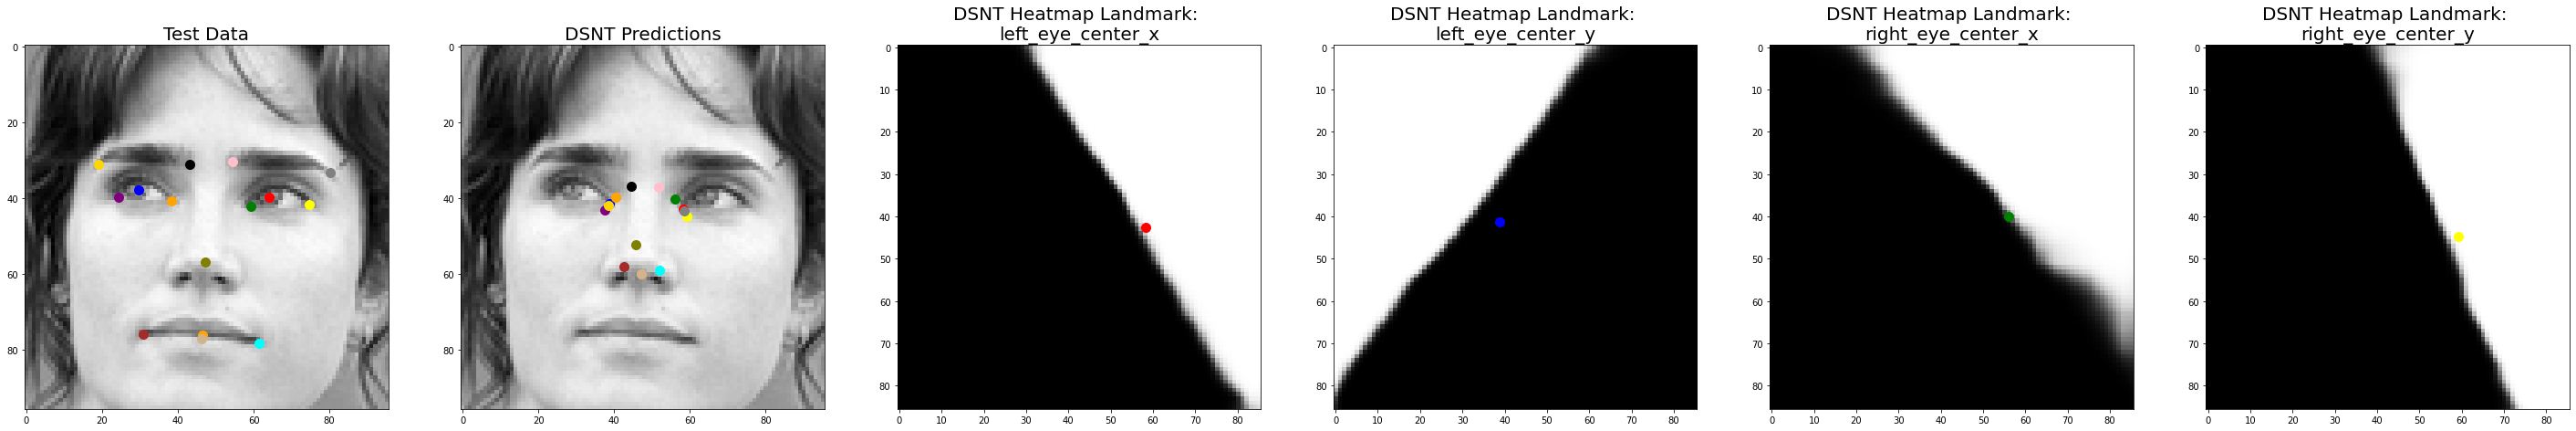

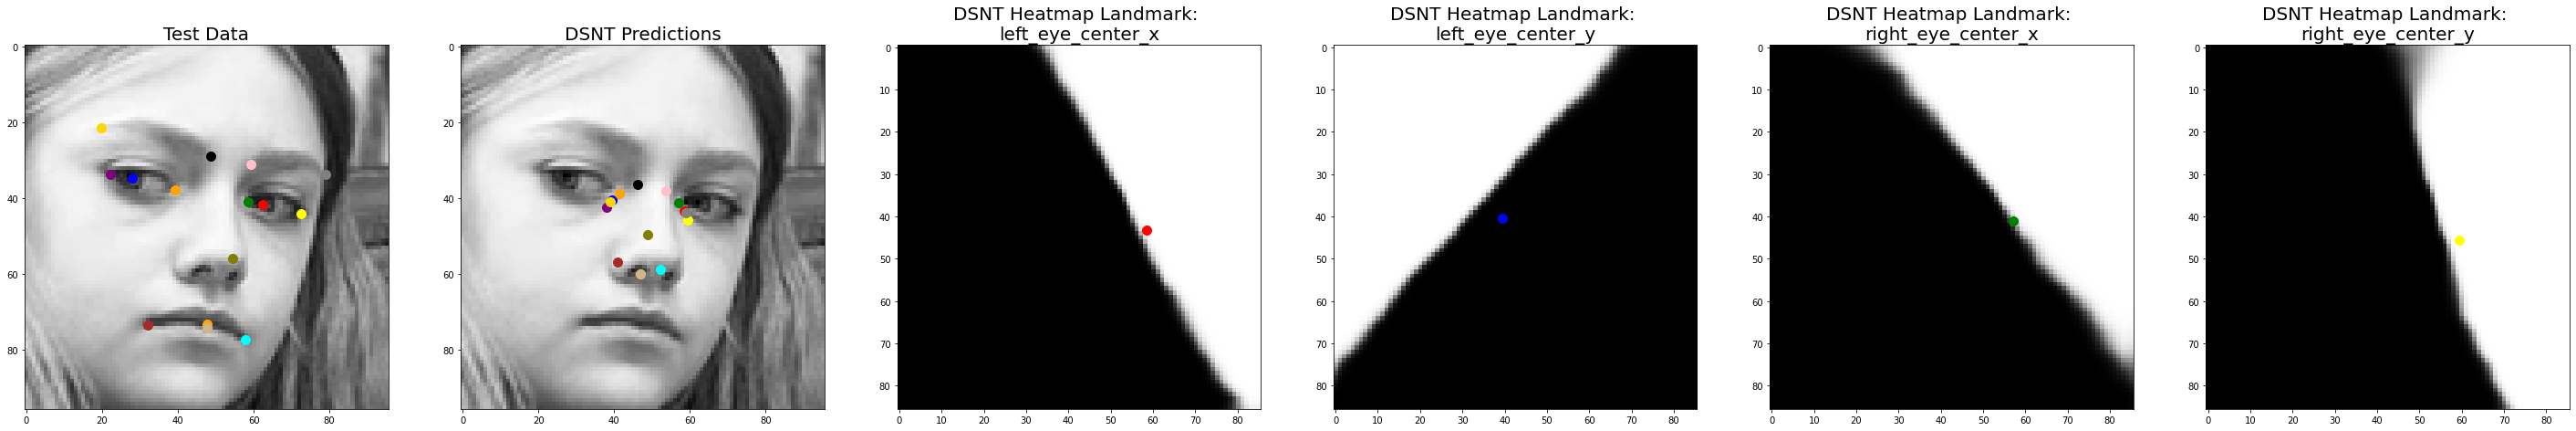

In [14]:
# Some visualizations
predictions = model.predict(xTest)
predictionPts =copy.deepcopy(predictions)
predictionPts *= 96
yTestPts = copy.deepcopy(yTest)
yTestPts *=96

dplbPredicts = pureDLV3.predict(xTest)

print(yTest[0][:1][:])
print(predictions.shape)
print(predictions[0][:1][:])

print("size of heatmaps {}".format(dplbPredicts.shape))

newPredicts = np.einsum('ijkl->iljk',dplbPredicts )
print(dplbPredicts.shape)
print(newPredicts.shape)


# Format of data is (Row Number aka image associated with, Specific Landmark, X & Y Coordinate)
colorDict = { 0:"red" ,1:"blue" , 2:"green" , 3:"yellow" , 4:"orange" ,
             5:"purple" , 6:"pink" , 7:"gray" , 8:"black" , 9:"gold" ,
             10:"olive" , 11:"cyan" , 12:"brown" , 13:"orange" , 14:"tan" }

for n in range(8):
    f, ax = plt.subplots(1, 6, figsize=(50,50))

    for i in range(15):
        ax[0].scatter(yTestPts[n][i][0], yTestPts[n][i][1],s=100, c = colorDict[i])
    ax[0].imshow(xTest[n], cmap='gray')
    ax[0].set_title( "Test Data", fontsize=20)


    for i in range(15):
        ax[1].scatter(predictionPts[n][i][0], predictionPts[n][i][1],s=100, c = colorDict[i])
    ax[1].imshow(xTest[n], cmap='gray')
    ax[1].set_title( "DSNT Predictions", fontsize=20)
    
    for y in range(4):
        ax[y+2].scatter(predictionPts[n][y][0], predictionPts[n][y][1],s=100, c = colorDict[y])
        ax[y+2].imshow(newPredicts[n][y], cmap='gray')
        ax[y+2].set_title( "DSNT Heatmap Landmark: \n{}".format(df.columns[y]), fontsize=20 )
        
    
    